# Prediction of Student Visa!



## Loading and Standardizing Data

In this notebook we will perform the following functions:
* Import Data
* Add Ranking of Universities
** importing ranking database and cleaning it
** creating a search_and_replace function
** applying search_and_replace function to find the rankings of our training_data universities
** add columns 'Matched_University' and 'Rank' in the training_data
* Dropping Extra Columns
* Handle Missing Values

In [59]:
import pandas as pd
import time
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import requests
import pickle

First, we read the csv of the training data from the drive and then organize

In [60]:
df1 = pd.read_csv(r"data\training_data\training_data_no_index.csv")
df2 = pd.read_csv(r"data\training_data\training_data_april_2024.csv")
df3 = pd.read_csv(r"data\training_data\training_data_new_0.csv")
df1.drop(['Id'], axis=1, inplace=True)
df2.drop(["Unnamed: 0", "Universities Applied", "Interview Location"], axis=1, inplace=True)
df2.rename(columns={"Visa Attempts" : "Visa Attempt", "Relatives in US" : "Relatives"}, inplace=True)
df3.drop(['Id', 'Unnamed: 0'], axis=1, inplace=True)
training_data = pd.concat([df1, df2, df3], ignore_index=False)

### Dropping duplicates
training_data.drop_duplicates(subset=['Program', 'University', 'Visa Result', 'Scholarship', 'Visa Attempt', 'Relatives'], inplace=True)

print(training_data.shape)
training_data.head(20)

(1047, 8)


,Program,Degree Level,University,Sponsor,Scholarship,Relatives,Visa Attempt,Visa Result
0,Criminal Justice,NaN,Western Michigan University,Uncle,NaN,Uncle,Second,Refused
1,NaN,NaN,NaN,NaN,NaN,NaN,Second (Refusal Category),NaN
2,NaN,NaN,DePaul University,Father,Yes,NaN,Refused,NaN
3,PhD in Physics,PhD,Purdue University,NaN,Fully funded,No,First,Approved
4,Cyber Security,Masters,UD,Uncle,NaN,Uncle,First,Refused
5,NaN,NaN,University of Wisconsin Milwaukee,Father,NaN,NaN,Second,Refused
6,MBA,Masters,Oklahoma City University,Parents,NaN,Father s,Third,Refused
7,NaN,NaN,Saint Cloud State University,Father,Yes,NaN,First,Refused
8,Nutrition in Psychology,Masters,Illinois State University,Mother,NaN,NaN,First,Refused
9,NaN,NaN,NaN,NaN,NaN,NaN,Second,Previously Refused


We have names of the universities. We can get the ranking of the university from internet and add it as a feature. An excel file was downloaded from the qs.com website which contains the university names and rankings.
Now, our job is to get the ranking of each university in our training data list and add a university ranking column in our dataset.

In [61]:
### import the ranking database ###

uni_data_dw = pd.read_csv(r"data\National Universities Rankings.csv", encoding='ANSI')

In [62]:
### Create a data with only university name and its rank ###

unis = uni_data_dw['Name']
ranks = uni_data_dw['Rank']

uni_ranks = pd.DataFrame({'University': unis, 'Rank': ranks})

#### University Ranking Search Engine

In [63]:
### test implementation of find_ranks ###
from utils import find_ranks
uni_name = 'cincinnati university'
uni_rank, rank, query = find_ranks(uni_name, uni_ranks, 'University', 'Rank')
print(f"The matched university and rank for name {uni_name}  is {query, rank}")

The matched university and rank for name cincinnati university  is ('University of Cincinnati', 142.0)


To search the university names from the ranking csv, it requires to have 'university' in the university name for the search function to pick up the uiversity name.

In [64]:
### Adding "University" to the university name if institute or university is not found ###

upd_uni = []
for university in training_data['University']:
    if isinstance(university, str):
        if not any("university" in word or "institute" in word or "college" in word for word in university.lower().split()):
            upd_uni.append(university + " University")
        else:
            upd_uni.append(university)
    else:
        upd_uni.append("N/A")

training_data['University'] = upd_uni
training_data.head()

,Program,Degree Level,University,Sponsor,Scholarship,Relatives,Visa Attempt,Visa Result
0,Criminal Justice,NaN,Western Michigan University,Uncle,NaN,Uncle,Second,Refused
1,NaN,NaN,N/A,NaN,NaN,NaN,Second (Refusal Category),NaN
2,NaN,NaN,DePaul University,Father,Yes,NaN,Refused,NaN
3,PhD in Physics,PhD,Purdue University,NaN,Fully funded,No,First,Approved
4,Cyber Security,Masters,UD University,Uncle,NaN,Uncle,First,Refused


Now we can see "Harvard University" instead of "Harvard".

In [65]:
### Search for the university name in the ranking database ###

found_ranks = []
found_uni_names = []
for university in training_data['University']:
    uni_rank, rank, query = find_ranks(university, uni_ranks, 'University', 'Rank')
    found_ranks.append(rank)
    found_uni_names.append(query)

In [66]:
# add the new column 'rank' to the dataframe
training_data = training_data.assign(Matched_University=found_uni_names, Rank = found_ranks)
training_data.sample(frac=1).head()

,Program,Degree Level,University,Sponsor,Scholarship,Relatives,Visa Attempt,Visa Result,Matched_University,Rank
203,Computer Science,Masters,University of Dayton,Father,Yes,NaN,First,Rejected (214b),University of Dayton,113.0
248,MS(IT),Masters,Westcliff University,NaN,NaN,NaN,First,"Refused\r\n\r\nAs an AI language model, I cann...",Westcliff University,240.0
576,NaN,NaN,Cleveland State University,NaN,NaN,NaN,NaN,Rejected,Cleveland State University,235.0
330,MPA,Masters,University of Alabama,NaN,NaN,NaN,First,Rejected,University of Alabama,103.0
127,NaN,NaN,Union College,Father,Yes,Yes,First,Approved,Rhodes College,130.0


### Handle Missing Values

In [67]:
training_data.replace("N/A", np.nan, inplace = True)

#  Identify missing values
missing_values = training_data.isnull().sum()
print(missing_values)

# Replace missing values
training_data.dropna(subset=['Visa Result'], inplace=True)
print(training_data.shape)
training_data.dropna(subset=['Matched_University'], inplace=True)
print(training_data.shape)
training_data['Rank'].fillna(1200, inplace=True)
training_data['University'].fillna(("Unknown"), inplace=True)
training_data['Matched_University'].fillna(("Unknown"), inplace=True)
training_data['Scholarship'].fillna(("No"), inplace=True)

# For categorical columns, fill with mode
training_data.fillna(training_data.mode().iloc[0], inplace=True)

Program               149
Degree Level          279
University            243
Sponsor               337
Scholarship           701
Relatives             663
Visa Attempt          149
Visa Result           119
Matched_University    265
Rank                    8
dtype: int64
(928, 10)
(708, 10)


### Standardizing the Data

In [68]:
from utils import standardize_strings
### Standardizing Degree Level
column = 'Degree Level'
degree_search_list = ['college', 'ms', 'master', 'grad', 'bachelor', 'bacca', 'Phd', 'bs', 'doctor']
degree_replace_list = [1, 3, 3, 3, 2, 2, 4, 2, 4]

train_data_std_1 = standardize_strings(training_data, degree_search_list, degree_replace_list, column, 3)
train_data_std_1['Degree Level'] = train_data_std_1['Degree Level'].astype(int)

The following values were not found in the 'replace_list': [4 'n/a (not mentioned)' 'f-1 univsersity' 'ph.d.' 'not provided'
 'specialist' 'not specified']


In [69]:
### Standardizing Sponsor

column = 'Sponsor'
sponsor_search_list = ['father', 'mother', 'parent', 'self', 'assistantship', 'fund', 'employer', 'supervisor', 'research', 'professor', 'loan', "HEC"]
sponsor_replace_list = ['Family', 'Family', 'Family', 'Self', 'University', 'University', 'Employer', 'University', 'University', 'University', 'Loan', "University"]
train_data_std_2 = standardize_strings(train_data_std_1, sponsor_search_list, sponsor_replace_list, column, 'Other')

The following values were not found in the 'replace_list': ['uncle' 'brother' 'husband' 'same' 'aunt' 'told' 'uncle and aunt' 'xyz'
 'cousin' 'family' 'global graduate  program' 'brother-in-law'
 'university' 'sister' 'aunt and uncle' 'friend' 'brother in law'
 'elder brother'
 'university (xyz university with the collaboration of the higher education commission of pakistan)'
 'first cousin' "husband's cousin" 'paternal uncle'
 'global graduate scholarship program' 'scholarship']


In [70]:
### Standardizing Scholarship

column = 'Scholarship'
sponsor_search_list = ['assistantship', '$', '%', 'No', 'k', 'USD', 'Yes', 'scholarship', 'fund', 'prof', 'merit', 'Automatic']
sponsor_replace_list = ['Full/Assistantship', 'Yes/Partial', 'Yes/Partial', 'No', 'Yes/Partial', 'Yes/Partial', 'Yes/Partial','Yes/Partial','Full/Assistantship', 'Full/Assistantship', 'Yes/Partial', 'Yes/Partial']
train_data_std_3 = standardize_strings(train_data_std_2, sponsor_search_list, sponsor_replace_list, column, 'No')


The following values were not found in the 'replace_list': ['out of state waiver' 'partial' 'full-tuition wavier and gra' '80'
 'graduate research assistant' 'full-tuition waiver and gra'
 'cps scholars award' 'full tuition' 'financial aid/student loan'
 'financial award' 'more than half tuition fee waived off' 'full coverage']


In [71]:
### Standardizing Scholarship

column = 'Program'
program_search_list = ['engineering', 'cs', 'Computer', 'information', 'it', 'Business', 'Health', 'Management', 'Science', 'Finance', 'MBA', 'cis', 'bba']
program_replace_list = ['Engineering', 'CS', 'CS', 'IT', 'IT','Business Studies', 'Medical St.', 'Management St.', 'Natural Sciences', 'Business Studies', 'Business Studies', 'CS', 'Business Studies']
train_data_std_4 = standardize_strings(train_data_std_3, program_search_list, program_replace_list, column, 'Other')


The following values were not found in the 'replace_list': ['criminal justice' 'marketing' 'biotechnology' 'ieli' 'biology'
 'public administration' 'bachelor' 'food technology and processing'
 'big data analysts' 'ece' 'environmental studies' 'transportation' 'phd'
 'nursing' 'cinematography and film/video production' 'undisclosed'
 'masters' 'energy systems' "master's" 'agriculture'
 'differential equations' 'electrical' 'msba' 'english course (pathway)'
 'ms in java' 'film' 'm.a higher education in academic advising'
 'chemistry' 'chemistry phd' 'academic intensive english' 'conference'
 'ms ba' 'career counseling' 'undergrad' 'peace and conflict studies'
 'mpa' 'public affairs'
 'criminal justice and law enforcement administration' 'master' 'law'
 'postdoc' 'ph.d.' 'n/a (not mentioned)' 'pathway' 'general studies'
 'psychology phd' 'pharmacy' 'accountancy' 'llm' 'psychology'
 'curriculum and instruction' 'bachelor of agriculture' 'geology'
 'commerce' "mpa (master's in public admin

In [72]:
### Standardizing Visa Result

column = 'Visa Result'
visa_search_list = ['221', 'processing', 'pending', 'N/A', 'Approved', 'Accepted', 'Refused', 'Rejected']
visa_replace_list = [1, 1, 1, 0, 1, 1, 0, 0]
train_data_std_5 = standardize_strings(train_data_std_4, visa_search_list, visa_replace_list, column, 0)
train_data_std_5['Visa Result'] = train_data_std_5['Visa Result'].astype(int)

The following values were not found in the 'replace_list': [0]


In [73]:
### Standardizing Relatives

column = 'Relatives'
relatives_search_list = ['Husband', 'Spouse', 'Brother', 'Sister', 'Father', 'Uncle', 'Mother', 'Aunt', 'No']
relatives_replace_list = ['Spouse', 'Spouse', 'Sibling(s)', 'Sibling(s)', 'Parents', 'Relative(s)', 'Parents', 'Relative(s)', 'No']
train_data_std_6 = standardize_strings(train_data_std_5, relatives_search_list, relatives_replace_list, column, 'No')

The following values were not found in the 'replace_list': ['n/a s' 'yes' 'cousin' 'friend' 'extended family' 'distant cousin s'
 'n/a\r\ns' 'distant cousin']


In [74]:
### Standardizing Visa Attempt
column = 'Visa Attempt'
attempt_search_list = ['st', 'nd', 'third', 'fourth', '1', '2', '3', 4, 'n/a', 'twice', 'renewal', 3]
attempt_replace_list = [1, 2, 3, 4, 1, 2, 3, 4, 1, 3, 1, 3]
train_data_std_7 = standardize_strings(train_data_std_6, attempt_search_list, attempt_replace_list, column, "3")

The following values were not found in the 'replace_list': [3]


In [75]:
train_data_std_7['Visa Attempt'].unique()

array(['2', '1', '3', '4'], dtype=object)

In [76]:
### Specifying the red_list universities ###
red_list = ['Wichita State University', 'Webster University', 'Adelphi University (NY)' , 'UD University' , 'Troy University', 'Saint Louis University', 'Mercer University', 'Full Sail University', 'Gannon University', 'Maharishi International University', 'University of New Haven', 'Westcliff University', 'St. cloud state university', 'Bay Atlantic University', 'Salem University', 'UD University', 'Dayton Unviersity', 'Cleveland State University']

with open('inference_files/red_listed_unis.pkl', 'wb') as file:
    pickle.dump(red_list, file)

train_data_std_7['Red List'] = np.where(train_data_std_7['University'].isin(red_list), 1, 0)

# Binning Rank #
train_data_std_7['Rank'] = pd.cut(train_data_std_7['Rank'], bins=[0, 50, 100, 200, 300, 400, 500, 1000, 2000], labels=[1, 2, 3, 4, 5, 6, 7, 8])

In [77]:
training_data = train_data_std_7.loc[:, ['Program', 'Degree Level', 'Scholarship','Sponsor', 'Relatives', 'Rank', 'Red List', 'Visa Attempt', 'Visa Result']]
target_data = train_data_std_7[['Visa Result']].astype(int)
training_data.sample(frac=1).head()

,Program,Degree Level,Scholarship,Sponsor,Relatives,Rank,Red List,Visa Attempt,Visa Result
284,CS,3,Full/Assistantship,Family,No,8,0,1,1
209,IT,3,No,Family,No,4,0,1,0
449,Engineering,3,Yes/Partial,Family,No,3,0,1,1
267,CS,2,No,Family,No,1,0,1,1
233,Business Studies,3,Yes/Partial,Other,Relative(s),3,0,2,0


## Exploratory Data Analysis

In [78]:
### Defining Colors
red = (231/256, 99/256, 118/256)
green = (166/256, 211/256, 160/256)
blue = (107/256, 127/256, 215/256)

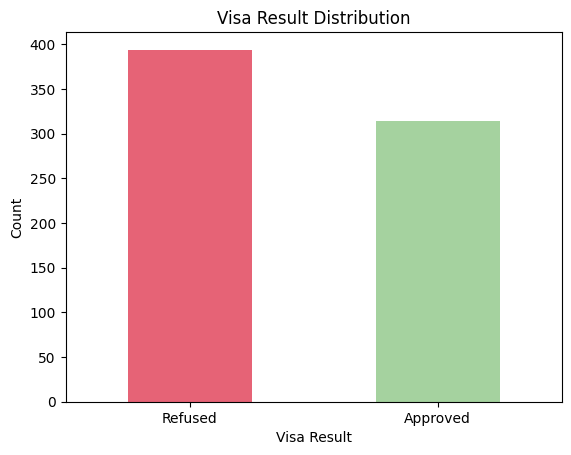

Refused to Approved Ratio: 1.25
Refused: 55.65%
Approved: 44.35%


In [79]:
import pandas as pd
import matplotlib.pyplot as plt

visa_result_df = train_data_std_7['Visa Result'].value_counts().sort_index()
visa_result_labels = {0: 'Refused', 1: 'Approved'}
visa_result_df.index = [visa_result_labels[i] for i in visa_result_df.index]

visa_result_df.plot(
    kind='bar',
    xlabel='Visa Result',
    ylabel='Count',
    title='Visa Result Distribution',
    color=[red, green],
    rot=0
)
plt.show()

rejected_count = visa_result_df['Refused']
approved_count = visa_result_df['Approved']
rejected_to_approved_ratio = rejected_count / approved_count

total_count = rejected_count + approved_count
rejected_percent = (rejected_count / total_count) * 100
approved_percent = (approved_count / total_count) * 100

print(f"Refused to Approved Ratio: {rejected_to_approved_ratio:.2f}")
print(f"Refused: {rejected_percent:.2f}%")
print(f"Approved: {approved_percent:.2f}%")

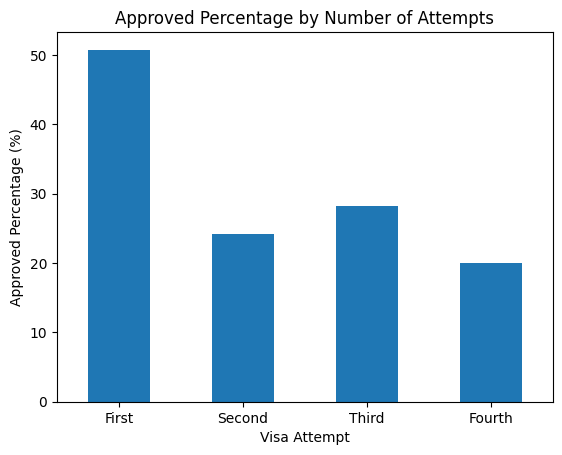

In [80]:
# Group by Visa Attempt and calculate the approved percentage
approved_percentage = train_data_std_7.groupby('Visa Attempt')['Visa Result'].mean() * 100

# Create bar plot
approved_percentage.plot.bar(rot=0)
custom_labels = ['First', 'Second', 'Third', 'Fourth']
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)
# Add labels and title
plt.xlabel("Visa Attempt")
plt.ylabel("Approved Percentage (%)")
plt.title("Approved Percentage by Number of Attempts")
plt.show()


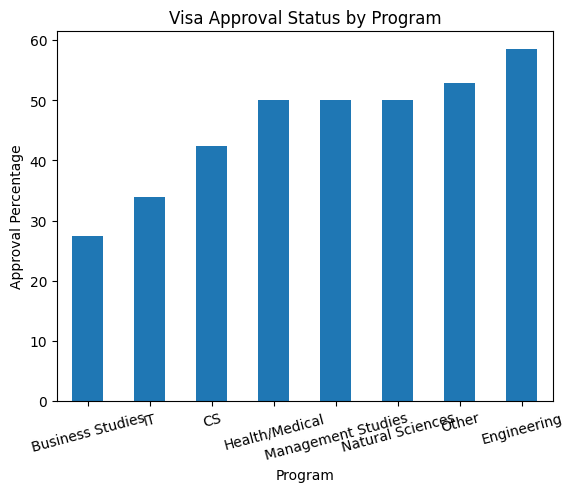

In [84]:
approved_percentage = (train_data_std_7.groupby('Program')['Visa Result'].mean() * 100).sort_values()

# Create bar plot
approved_percentage.plot.bar(rot=0)

# Add labels and title
plt.xlabel("Program")
plt.ylabel("Approval Percentage")
plt.xticks(rotation=15)

plt.title("Visa Approval Status by Program")
# Show the chart
plt.show()

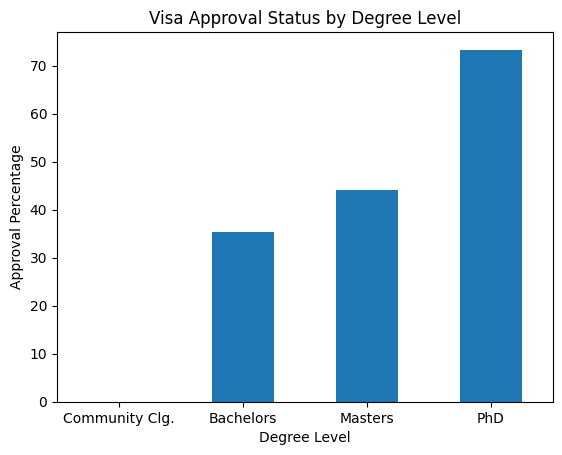

In [49]:
approved_percentage = (train_data_std_7.groupby('Degree Level')['Visa Result'].mean() * 100).sort_values()

# Create bar plot
approved_percentage.plot.bar(rot=0)

# Add labels and title
plt.xlabel("Degree Level")
plt.ylabel("Approval Percentage")
custom_labels = ['Community Clg.', 'Bachelors', 'Masters', 'PhD']
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)
plt.title("Visa Approval Status by Degree Level")
# Show the chart
plt.show()

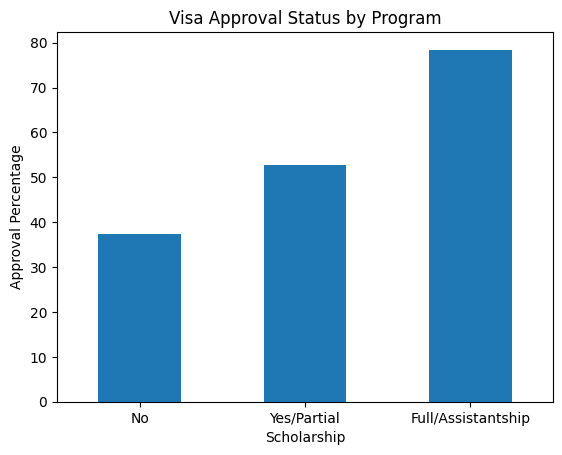

In [47]:
approved_percentage = (train_data_std_7.groupby('Scholarship')['Visa Result'].mean() * 100).sort_values()

# Create bar plot
approved_percentage.plot.bar(rot=0)

# Add labels and title
plt.xlabel("Scholarship")
plt.ylabel("Approval Percentage")
plt.title("Visa Approval Status by Scholarship")
# Show the chart
plt.show()

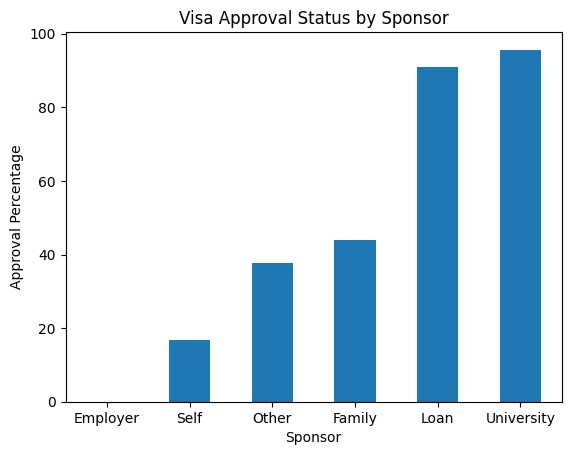

In [50]:
approved_percentage = (train_data_std_7.groupby('Sponsor')['Visa Result'].mean() * 100).sort_values()

# Create bar plot
approved_percentage.plot.bar(rot=0)

# Add labels and title
plt.xlabel("Sponsor")
plt.ylabel("Approval Percentage")
plt.title("Visa Approval Status by Sponsor")
# Show the chart
plt.show()

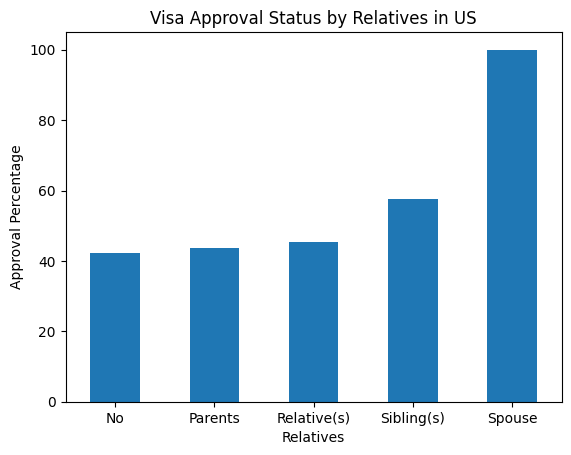

In [52]:
approved_percentage = (train_data_std_7.groupby('Relatives')['Visa Result'].mean() * 100).sort_values()

# Create bar plot
approved_percentage.plot.bar(rot=0)

# Add labels and title
plt.xlabel("Relatives")
plt.ylabel("Approval Percentage")
plt.title("Visa Approval Status by Relatives in US")
# Show the chart
plt.show()

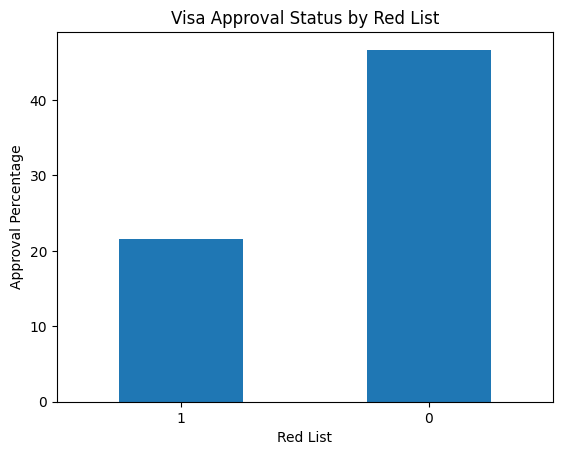

In [54]:
approved_percentage = (train_data_std_7.groupby('Red List')['Visa Result'].mean() * 100).sort_values()

# Create bar plot
approved_percentage.plot.bar(rot=0)

# Add labels and title
plt.xlabel("Red List")
plt.ylabel("Approval Percentage")
plt.title("Visa Approval Status by Red List")
# Show the chart
plt.show()

## Pre-Processing

In [72]:
### Breaking Down Data into Numeric and Categorical Features ###
numeric_columns = ['Visa Attempt', 'Degree Level', 'Rank', 'Red List', 'Visa Result']
cat_columns = ['Program', 'Scholarship', 'Sponsor','Relatives'] # 'Sponsor' is not included because it worsned the model

In [73]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle

encoder = OneHotEncoder(sparse_output=False)
encoder.fit(training_data[cat_columns])

with open('inference_files/onehot_encoder.pkl', 'wb') as f:
   pickle.dump(encoder, f)

training_data_num = training_data[numeric_columns]
training_data_cat_np = encoder.transform(training_data[cat_columns])
training_data_cat = pd.DataFrame(data=training_data_cat_np, columns = encoder.get_feature_names_out(input_features=cat_columns))

In [74]:
target_data.reset_index(drop=True, inplace=True)
training_data_cat.reset_index(drop=True, inplace=True)
training_data_num.reset_index(drop=True, inplace=True)
training_data_num = training_data_num.astype(int)
training_data = pd.concat([training_data_num, training_data_cat], axis=1, ignore_index=False)
training_data.head()

,Visa Attempt,Degree Level,Rank,Red List,Visa Result,Program_Business,Program_Business Studies,Program_CS,Program_Engineering,Program_Health/Medical,...,Sponsor_Family,Sponsor_Loan,Sponsor_Other,Sponsor_Self,Sponsor_University,Relatives_No,Relatives_Parents,Relatives_Relative(s),Relatives_Sibling(s),Relatives_Spouse
0,2,3,3,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,4,2,0,1,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,3,3,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2,3,1,0,0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3,3,3,0,0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [75]:
target_train = training_data['Visa Result']
features_train = training_data.drop(['Visa Result'], axis=1)

## Machine Learning Model

In [76]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(features_train, target_train, test_size = 0.2)

#### Handling Data Imbalance

In [77]:
### Handling Imbalanced Data using SMOTE ###
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

sm = ADASYN(random_state=27)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [78]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# fix the randomization
np.random.seed(30)
tf.random.set_seed(30)

# Scale the data
scaler = StandardScaler()
X_train_scaled = (X_train)
X_test_scaled = (X_test)

with open('inference_files/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Convert the data to TensorFlow tensors
X_train_scaled = tf.convert_to_tensor(X_train_scaled, dtype=tf.float32)
y_train_scaled = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test_scaled = tf.convert_to_tensor(X_test_scaled, dtype=tf.float32)
y_test_scaled = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [79]:
lamda = 0.005  
dropout_rate = 0.1

model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lamda), input_dim=X_train.shape[1]),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lamda)),
    tf.keras.layers.Dropout(dropout_rate), 
    tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lamda)),
    tf.keras.layers.Dropout(dropout_rate), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_test_scaled, y_test_scaled), verbose=0)

# Make predictions on the training set
y_pred_train = model.predict(X_train_scaled)

19/19 [==============================] - 0s 667us/step


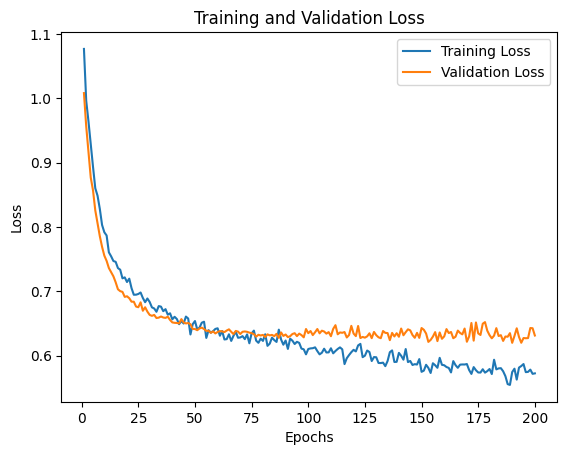

In [80]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure()
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

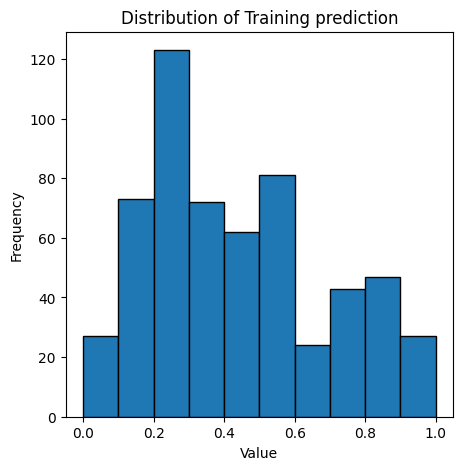

In [81]:
# Define the bin edges.
bins = np.arange(0, 1.1, 0.1)

plt.figure(figsize=(5, 5))
plt.hist(y_pred_train, bins=bins, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Training prediction')

# Show the plot.
plt.show()

5/5 [==============================] - 0s 1ms/step


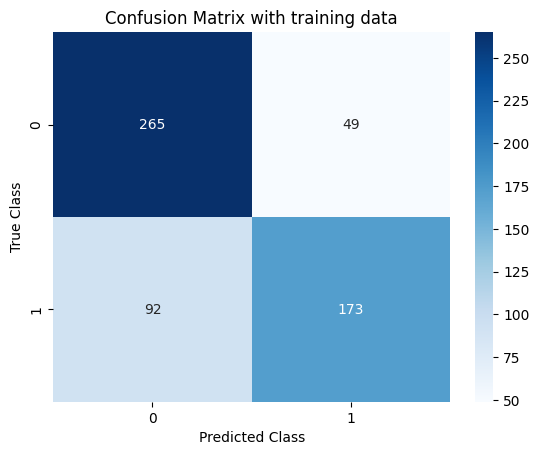

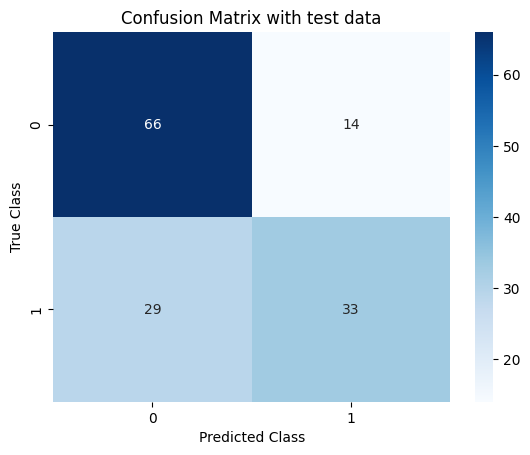

The accuracy with training data is 0.7564766839378239
The accuracy with test data is 0.6971830985915493
Precision: 0.7021276595744681
Recall: 0.532258064516129
F1 Score: 0.6055045871559632


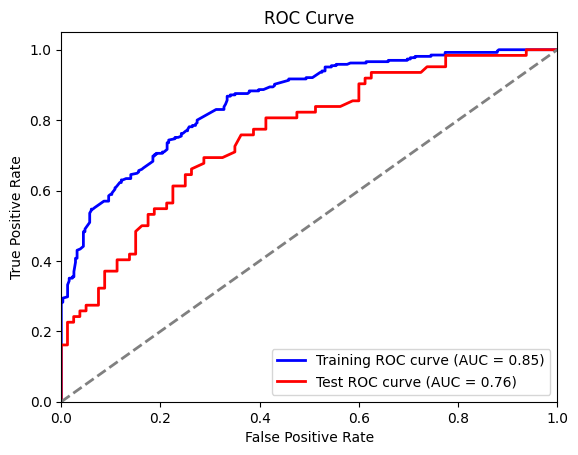

In [82]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix and accuracy for training data
y_pred_train_bin = y_pred_train > 0.5
y_pred_train_bin = y_pred_train_bin[:, 0]
conf_matrix_train = confusion_matrix(y_train, y_pred_train_bin)
accuracy_train = accuracy_score(y_train, y_pred_train_bin)

# Confusion matrix and accuracy for test data
y_pred_test = model.predict(X_test_scaled)
y_pred_test_bin = y_pred_test > 0.5
y_pred_test_bin = y_pred_test_bin[:, 0]
conf_matrix_test = confusion_matrix(y_test, y_pred_test_bin)
accuracy_test = accuracy_score(y_test, y_pred_test_bin)

# Plot confusion matrix for training data
sns.heatmap(conf_matrix_train, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix with training data")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# Plot confusion matrix for test data
sns.heatmap(conf_matrix_test, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix with test data")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# Print training and test accuracies
print(f"The accuracy with training data is {accuracy_train}")
print(f"The accuracy with test data is {accuracy_test}")

# Calculate precision, recall, and F1 scores for training data
precision_train = precision_score(y_train, y_pred_train_bin)
recall_train = recall_score(y_train, y_pred_train_bin)
f1_train = f1_score(y_train, y_pred_train_bin)

# Calculate precision, recall, and F1 scores for test data
precision_test = precision_score(y_test, y_pred_test_bin)
recall_test = recall_score(y_test, y_pred_test_bin)
f1_test = f1_score(y_test, y_pred_test_bin)

# Print the precision, recall, and F1 score for test set
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")

# Calculate ROC curve and AUC for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train[:, 0])
roc_auc_train = auc(fpr_train, tpr_train)

# Calculate ROC curve and AUC for test data
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test[:, 0])
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for both training and test data
plt.figure()
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Training ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

5/5 [==============================] - 0s 999us/step


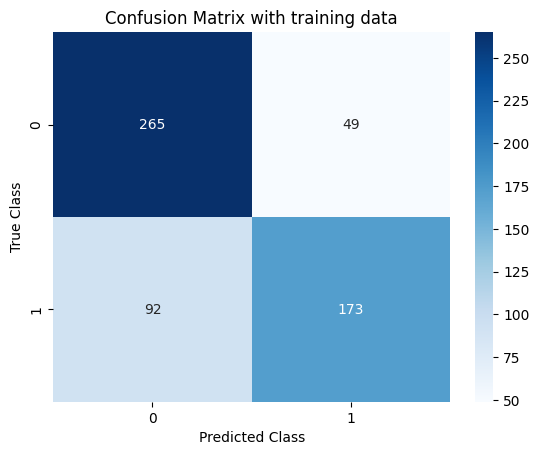

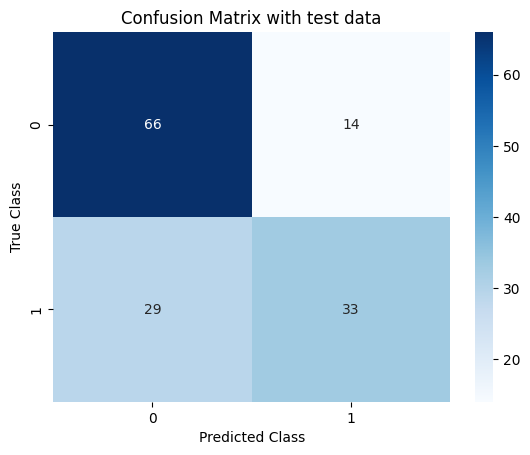

The accuracy with training data is 0.7564766839378239
The accuracy with test data is 0.6971830985915493
Precision: 0.7021276595744681
Recall: 0.532258064516129
F1 Score: 0.6055045871559632


In [83]:
y_pred_train_bin = y_pred_train > .5
y_pred_train_bin = y_pred_train_bin[:, 0]
conf_matrix_train = confusion_matrix(y_train, y_pred_train_bin)
accuracy_train = accuracy_score(y_train, y_pred_train_bin)

y_pred_test = model.predict(X_test_scaled)
y_pred_test_bin = y_pred_test > .5
y_pred_test_bin = y_pred_test_bin[:, 0]
conf_matrix_test = confusion_matrix(y_test, y_pred_test_bin)
accuracy_test = accuracy_score(y_test, y_pred_test_bin)

sns.heatmap(conf_matrix_train, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix with training data")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

sns.heatmap(conf_matrix_test, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix with test data")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

print(f"The accuracy with training data is {accuracy_train}")
print(f"The accuracy with test data is {accuracy_test}")

### calculating the precision, recall and f1 score ###
precision_train = precision_score(y_train, y_pred_train_bin)
recall_train = recall_score(y_train, y_pred_train_bin)
f1_train = f1_score(y_train, y_pred_train_bin)

precision_test = precision_score(y_test, y_pred_test_bin)
recall_test = recall_score(y_test, y_pred_test_bin)
f1_test = f1_score(y_test, y_pred_test_bin)

### printing the precision, recall and f1 score for test set
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")

#### Saving the Model's Weights

In [84]:
#### Saving the Model weights ####
tf.saved_model.save(model, 'inference_files/model')

INFO:tensorflow:Assets written to: inference_files/model\assets


INFO:tensorflow:Assets written to: inference_files/model\assets


### Random Forest

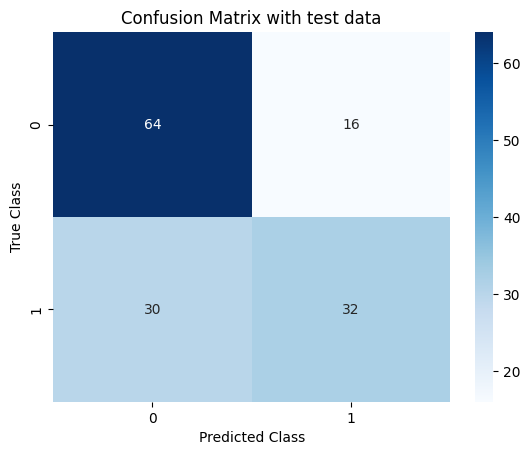

Accuracy: 0.676056338028169
Precision: 0.6666666666666666
Recall: 0.5161290322580645
F1 Score: 0.5818181818181819


In [85]:
### applying random forest classifier ###
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Create the model with 100 trees
abc = AdaBoostClassifier(n_estimators=500, random_state=27, learning_rate=0.1)

# Train the model on training data
abc.fit(X_train, y_train)

# Use the forest's predict method on the test data
y_pred = abc.predict(X_test)

# Calculate and display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix with test data")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

### Callucating precison, recall and f1 score ###
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

### Results

Thus, we conclude that neural network is outperforming the decision trees in this case. Here are some further findings:
1. There is only limited information available in our features. Thus, many same features predict different output. The reason is that our features do not contain that extra piece of information to predict the correct outcome. 
2. The analysis tells that some information is hidden in the actual profile, like past university and course alignment etc. This is not possible to gather the data for all these and train a model on these.
3. We will use the eights of neural networks and use the probability to tell how strong the visa chances for a particular candidate are.

In [86]:
### calling the saved model ###

model = tf.saved_model.load('inference_files/model')
model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x1e394bc4340>